In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import cv2

In [3]:
coins_8labels = pickle.load(open('./Output/data/coins_arrays_8label.pkl',"rb"))

In [6]:
coins_au = coins_8labels[coins_8labels['label'].isin((["10c","20c",'50c']))]

In [7]:
coins_au['label'].unique()

array(['10c', '50c', '20c'], dtype=object)

In [8]:
coins_au.shape

(38480, 2)

In [9]:
coins_au.head()

,image,label
0,"[[[27, 81, 110], [94, 165, 195], [30, 85, 117]...",10c
1,"[[[227, 229, 229], [224, 226, 226], [214, 216,...",10c
2,"[[[58, 74, 97], [32, 47, 71], [28, 44, 67], [5...",10c
3,"[[[60, 92, 127], [44, 75, 108], [65, 93, 123],...",10c
4,"[[[63, 71, 126], [53, 65, 121], [61, 76, 136],...",10c


In [10]:
coins_au_dumm = pd.get_dummies(coins_au['label'])
coins_au_dumm['gt'] = coins_au_dumm.apply(lambda x: pd.Series([x.values]), axis=1)
coins_au_gt=coins_au.join(coins_au_dumm)

In [11]:
coins_au_gt.head()

,image,label,10c,20c,50c,gt
0,"[[[27, 81, 110], [94, 165, 195], [30, 85, 117]...",10c,1,0,0,"[1, 0, 0]"
1,"[[[227, 229, 229], [224, 226, 226], [214, 216,...",10c,1,0,0,"[1, 0, 0]"
2,"[[[58, 74, 97], [32, 47, 71], [28, 44, 67], [5...",10c,1,0,0,"[1, 0, 0]"
3,"[[[60, 92, 127], [44, 75, 108], [65, 93, 123],...",10c,1,0,0,"[1, 0, 0]"
4,"[[[63, 71, 126], [53, 65, 121], [61, 76, 136],...",10c,1,0,0,"[1, 0, 0]"


In [ ]:
coins_au_gt['gt'].unique()

In [16]:
img_rows, img_cols, img_channels = 70, 70, 3
input_shape=(img_rows, img_cols, img_channels)
num_classes=3

In [13]:
X = np.stack(coins_au_gt['image'])/255.0
y = np.stack(coins_au_gt['gt'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adadelta',
              metrics=['accuracy'])

In [48]:
batch_size = 50
epochs = 10

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 30784 samples, validate on 7696 samples
Epoch 1/10
30784/30784 [==============================] - 440s 14ms/step - loss: 0.8970 - accuracy: 0.5321 - val_loss: 0.5711 - val_accuracy: 0.7399
Epoch 2/10
30784/30784 [==============================] - 436s 14ms/step - loss: 0.5620 - accuracy: 0.7368 - val_loss: 0.3930 - val_accuracy: 0.8488
Epoch 3/10
30784/30784 [==============================] - 425s 14ms/step - loss: 0.3922 - accuracy: 0.8397 - val_loss: 0.2099 - val_accuracy: 0.9302
Epoch 4/10
30784/30784 [==============================] - 392s 13ms/step - loss: 0.2774 - accuracy: 0.8940 - val_loss: 0.1921 - val_accuracy: 0.9278
Epoch 5/10
30784/30784 [==============================] - 382s 12ms/step - loss: 0.2058 - accuracy: 0.9201 - val_loss: 0.1149 - val_accuracy: 0.9602
Epoch 6/10
30784/30784 [==============================] - 419s 14ms/step - loss: 0.1611 - accuracy: 0.9410 - val_loss: 0.1675 - val_accuracy: 0.9392
Epoch 7/10
30784/30784 [==============================] -

In [49]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.057810546248461936
Test accuracy: 0.9758316278457642


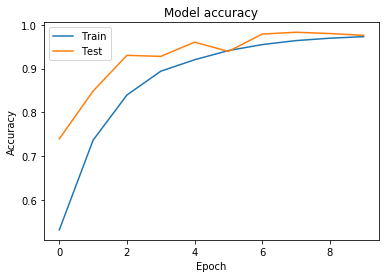

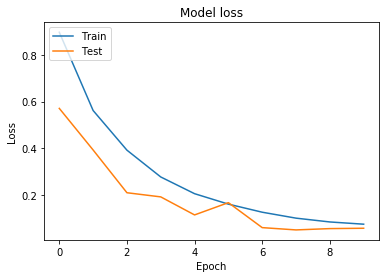

In [50]:

%matplotlib inline
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

[2 0 2 ... 2 2 0]
[2 0 2 ... 2 1 0]


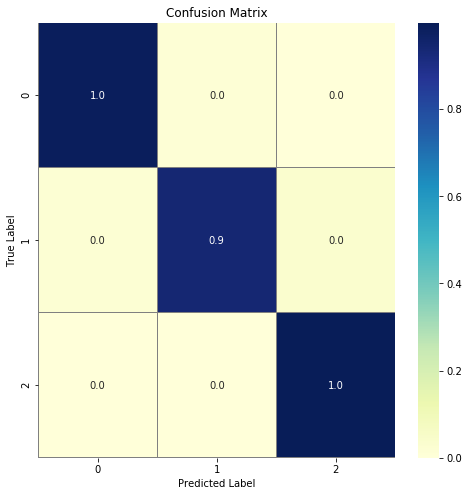

In [51]:
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Guardar modelo

In [44]:
moment=time.localtime()
name='Model_AU_{}_{}-{}-{}.h5'.format(model.history.history["val_accuracy"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [45]:
model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name)

# Predicciones reales

In [24]:
from src.predict import whoIamAU

transforming image from new_images/50c_1.jpg
transf img shape:  (1, 70, 70, 3)
Prediccion:  [2.6887103e-18 6.4916203e-05 9.9993503e-01]
(1, 226, 223, 3)


'Probs -> 10c:0.00000 20c:0.00006 50c:0.99994'

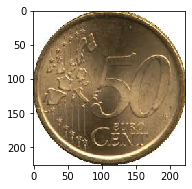

In [52]:
path00 = 'new_images/50c_1.jpg'
whoIamAU(path00,model)

transforming image from new_images/10c1.jpg
transf img shape:  (1, 70, 70, 3)
Prediccion:  [4.5036245e-17 6.7917761e-05 9.9993205e-01]
(1, 225, 224, 3)


'Probs -> 10c:0.00000 20c:0.00007 50c:0.99993'

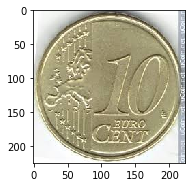

In [53]:
path0 = 'new_images/10c1.jpg'
whoIamAU(path0,model)


transforming image from new_images/20c1.jpg
transf img shape:  (1, 70, 70, 3)
Prediccion:  [1.3250444e-10 9.9801719e-01 1.9828386e-03]
(1, 1022, 1085, 3)


'Probs -> 10c:0.00000 20c:0.99802 50c:0.00198'

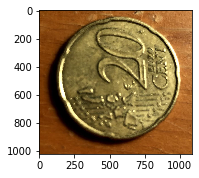

In [54]:
path1 = 'new_images/20c1.jpg'
whoIamAU(path1, model)

transforming image from new_images/10c2.jpg
transf img shape:  (1, 70, 70, 3)
Prediccion:  [0.00116671 0.84007657 0.15875676]
(1, 969, 976, 3)


'Probs -> 10c:0.00117 20c:0.84008 50c:0.15876'

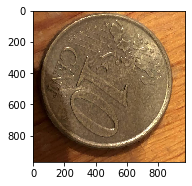

In [55]:
path2 = 'new_images/10c2.jpg'
whoIamAU(path2,model)